## Import the Libraries

In [70]:
import pandas as pd
import dowhy as dy

## Load the data

In [71]:
raw_data = pd.read_csv("owid-covid-data.csv")
raw_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_r

In [129]:
raw_data[raw_data.location == 'New Zealand']['hospital_beds_per_thousand']

39308    2.61
39309    2.61
39310    2.61
39311    2.61
39312    2.61
         ... 
39621    2.61
39622    2.61
39623    2.61
39624    2.61
39625    2.61
Name: hospital_beds_per_thousand, Length: 318, dtype: float64

## 1. Original casual model proposed by the paper 

## Get the date of first case reported 

In [73]:
## Convert the date column to be in the form of day, month, year.
df = raw_data.copy()
df['date']= pd.to_datetime(df['date'], infer_datetime_format=True)
#df = df.dropna(subset=['stringency_index','total_deaths_per_million'])
df = df.dropna(subset=['stringency_index'])


In [74]:
list_of_countries = df.location.unique()
print("There are {} unique country names in the dataset".format(len(list_of_countries)))

There are 181 unique country names in the dataset


In [75]:
#drop the world and international rows 
countries_df = df.copy()
countries_df = countries_df.drop(df[df['location'].isin(['World','International'])].index, axis =0)

In [76]:
list_of_countries = countries_df.location.unique()

In [77]:
list_of_countries = list(list_of_countries)

### Calculate the date for first covid case per country

In [78]:
#def get_first_date_for_an_event(data, list_of_countries, column_of_interest):
import numpy as np
dates_of_first_case = []
dates_of_index_40 = []
countries = []
total_deaths_per = []
for i in list_of_countries:
    cases_indeces = countries_df[countries_df['location']== i][['date','new_cases','stringency_index','total_deaths_per_million']]
    firs_case_date = min(cases_indeces[cases_indeces.new_cases != 0]['date'])
    total_deaths_per_updated = cases_indeces['total_deaths_per_million'].max(skipna = True)
    try:
        date_of_index_40 = min(cases_indeces[cases_indeces.stringency_index >= 40]['date'])
        dates_of_index_40.append(date_of_index_40)
        dates_of_first_case.append(firs_case_date)
        total_deaths_per.append(total_deaths_per_updated)
        countries.append(i)
    except ValueError as e:
        j = max(cases_indeces['stringency_index'])
        print("Country {} had an index of {}lockdown measures".format(i,j))
#all_cases_dates = aruba_cases.new_cases    

Country Burundi had an index of 14.81lockdown measures
Country Belarus had an index of 22.22lockdown measures
Country Nicaragua had an index of 16.67lockdown measures
Country Taiwan had an index of 30.56lockdown measures


In [79]:
list_dates = list(zip(countries,dates_of_first_case, dates_of_index_40,total_deaths_per))


In [122]:
all_countries = pd.DataFrame(list_dates, columns=['Country','First_case_of_covid','stringency_index_date','total_deaths_per_million'])
all_countries = all_countries.dropna()
all_countries['Delta_days'] = (all_countries['stringency_index_date'] - all_countries['First_case_of_covid']).dt.days
data = all_countries

## Verify that dates were capture correctly. 

In [123]:
#new_zealand had the first case on 2020-02-28
data[data['Country']== 'New Zealand']

,Country,First_case_of_covid,stringency_index_date,total_deaths_per_million,Delta_days
120,New Zealand,2020-02-28,2020-03-21,5.184,22


## Build the casual model

In [124]:
data = pd.DataFrame(data=
                    {
                     'total_deaths_per_million': data['total_deaths_per_million'],
                     'Delta_days': data['Delta_days']
                     }
                   )

In [125]:
model= dy.CausalModel(
    data = data,
    treatment = 'Delta_days',
    outcome = 'total_deaths_per_million',
    graph = """graph[directed 1 node[id "Delta_days" label "Delta_days"]
                node[id "total_deaths_per_million" label "total_deaths_per_million"]
                edge[source "Delta_days" target "total_deaths_per_million"]]"""
                )


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Delta_days'] on outcome ['total_deaths_per_million']


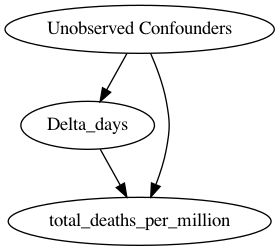

In [126]:

from IPython.display import Image, display
model.view_model()
display(Image(filename="causal_model.png"))

In [127]:
identified_estimand = model.identify_effect()


INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [97]:
print(identified_estimand)


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                           
─────────(Expectation(total_deaths_per_million))
d[Δ_days]                                       
Estimand assumption 1, Unconfoundedness: If U→{Delta_days} and U→total_deaths_per_million then P(total_deaths_per_million|Delta_days,,U) = P(total_deaths_per_million|Delta_days,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [128]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",test_significance=True )
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: total_deaths_per_million~Delta_days
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.030
Model:                                  OLS   Adj. R-squared:                  0.024
Method:                       Least Squares   F-statistic:                     4.962
Date:                      Mon, 16 Nov 2020   Prob (F-statistic):             0.0273
Time:                              19:56:27   Log-Likelihood:                -1130.1
No. Observations:                       163   AIC:                             2264.
Df Residuals:                           161   BIC:                             2270.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
               

In [99]:
from dowhy.causal_refuters.placebo_treatment_refuter import PlaceboTreatmentRefuter
refuter = PlaceboTreatmentRefuter(data=data, identified_estimand=identified_estimand, estimate=estimate, placebo_type='permute')
print(refuter.refute_estimate())

                          1.952   Prob(JB):                     2.26e-41
Kurtosis:                       6.511   Cond. No.                         30.5

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.006
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.9976
Date:                      Mon, 16 Nov 2020   Prob (F-statistic):              0.319
Time:                              14:00:04   Log-Likelihood:                -1132.1
No. Observations:                       163   AIC:                             2268.
Df Residuals:                           161   BIC:                             2274.
Df Model:                                 1                      

## 2. Proposed casual model 

## Get GDP, Total cases per milion, number of hospital beds, countries

In [82]:
all_countries.head(5)


,Country,First_case_of_covid,stringency_index_date,total_deaths_per_million,Delta_days
0,Aruba,2020-03-13,2020-03-21,355.919,8
1,Afghanistan,2020-02-25,2020-03-18,40.125,22
2,Angola,2020-03-22,2020-03-27,8.367,5
4,Albania,2020-03-09,2020-03-10,201.195,1
5,Andorra,2020-03-03,2020-03-25,970.685,22


In [130]:
additional_info_df = countries_df.copy()
additional_info_df = additional_info_df[['location','gdp_per_capita','hospital_beds_per_thousand','total_cases_per_million']]

In [131]:
countries_df = df.copy()

In [135]:
gdp_per_capit = []
hospital_beds_per_thousand = []
total_cases_per_million = []
for i in additional_info_df.location.unique():
    cases_indeces = countries_df[countries_df['location']== i][['gdp_per_capita','hospital_beds_per_thousand','total_cases_per_million']]
    gdp_per_capit.append(cases_indeces.gdp_per_capita.max(skipna = True))
    hospital_beds_per_thousand.append(cases_indeces.hospital_beds_per_thousand.mean(skipna = True))
    total_cases_per_million.append(cases_indeces.total_cases_per_million.max(skipna = True))


    

In [140]:
countries = additional_info_df.location.unique()
full_clean_data_1 = list(zip(countries,gdp_per_capit, hospital_beds_per_thousand,total_cases_per_million))


In [141]:
full_data_data_2 = pd.DataFrame(full_clean_data_1, columns=['Country','gdp_per_capita','hospital_beds_per_thousand','total_cases_per_million'])

In [143]:
full_data_data_2.dropna()

,Country,gdp_per_capita,hospital_beds_per_thousand,total_cases_per_million
1,Afghanistan,1803.987,0.50,1082.990
4,Albania,11803.431,2.89,8789.353
6,United Arab Emirates,67293.483,1.20,14371.815
7,Argentina,18933.907,5.00,26682.028
8,Australia,44648.710,3.84,1082.750
...,...,...,...,...
175,Vietnam,6171.884,2.60,12.123
177,Yemen,1479.147,0.70,69.403
178,South Africa,12294.876,2.32,12135.051
179,Zambia,3689.251,2.00,888.003


In [144]:
full_data_clean =  pd.merge(full_data_data_2,
                 all_countries,
                 on='Country', 
                 how='right')


In [145]:
full_data_clean = full_data_clean.dropna()

In [146]:
full_data_clean

,Country,gdp_per_capita,hospital_beds_per_thousand,total_cases_per_million,First_case_of_covid,stringency_index_date,total_deaths_per_million,Delta_days
1,Afghanistan,1803.987,0.50,1082.990,2020-02-25,2020-03-18,40.125,22
3,Albania,11803.431,2.89,8789.353,2020-03-09,2020-03-10,201.195,1
5,United Arab Emirates,67293.483,1.20,14371.815,2020-01-27,2020-03-16,51.970,49
6,Argentina,18933.907,5.00,26682.028,2020-03-04,2020-03-16,719.536,12
7,Australia,44648.710,3.84,1082.750,2020-01-25,2020-03-19,35.569,54
...,...,...,...,...,...,...,...,...
157,Vietnam,6171.884,2.60,12.123,2020-01-24,2020-02-13,0.360,20
159,Yemen,1479.147,0.70,69.403,2020-04-10,2020-04-10,20.184,0
160,South Africa,12294.876,2.32,12135.051,2020-02-07,2020-03-18,322.229,40
161,Zambia,3689.251,2.00,888.003,2020-03-19,2020-03-27,18.930,8


In [147]:
data = pd.DataFrame(data=
                    {
                     'total_deaths_per_million': full_data_clean['total_deaths_per_million'],
                     'Delta_days': full_data_clean['Delta_days'],
                     'gdp_per_capita': full_data_clean['gdp_per_capita'],
                     'total_cases_per_million': full_data_clean['total_cases_per_million'],
                     'hospital_beds_per_thousand': full_data_clean['hospital_beds_per_thousand']
                     }
                   )

In [148]:
model= dy.CausalModel(
    data = data,
    treatment = 'Delta_days',
    outcome = 'total_deaths_per_million',
    graph = """graph[directed 1 node[id "Delta_days" label "Delta_days"]
                node[id "total_deaths_per_million" label "total_deaths_per_million"]
                node[id "gdp_per_capita" label "gdp_per_capita"]
                node[id "total_cases_per_million" label "total_cases_per_million"]
                node[id "hospital_beds_per_thousand" label "hospital_beds_per_thousand"]
                edge[source "Delta_days" target "total_deaths_per_million"]
                edge[source "Delta_days" target "total_cases_per_million"]
                edge[source "gdp_per_capita" target "hospital_beds_per_thousand"]
                edge[source "hospital_beds_per_thousand" target "total_deaths_per_million"]
                edge[source "total_cases_per_million" target "total_deaths_per_million"]
                edge[source "gdp_per_capita" target "Delta_days"]]"""
                )


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Delta_days'] on outcome ['total_deaths_per_million']


In [101]:
pip install pygraphviz 

Note: you may need to restart the kernel to use updated packages.


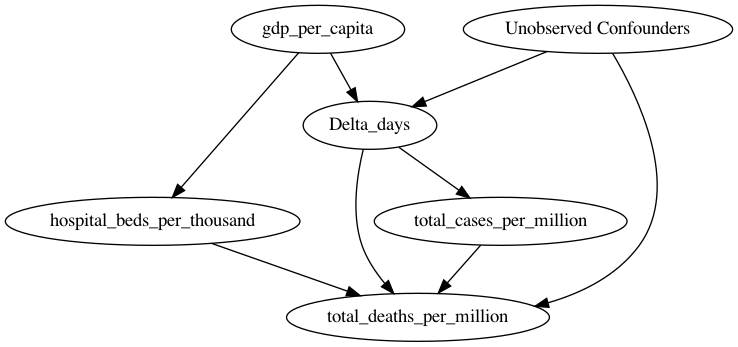

In [149]:
from IPython.display import Image, display

model.view_model(layout="dot")

display(Image(filename="causal_model.png"))

In [150]:
identified_estimand = model.identify_effect()


INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['gdp_per_capita', 'U']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [151]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: total_deaths_per_million~Delta_days+gdp_per_capita+Delta_days*total_cases_per_million+Delta_days*hospital_beds_per_thousand
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.373
Model:                                  OLS   Adj. R-squared:                  0.354
Method:                       Least Squares   F-statistic:                     19.33
Date:                      Mon, 16 Nov 2020   Prob (F-statistic):           1.69e-12
Time:                              20:05:34   Log-Likelihood:                -909.47
No. Observations:                       135   AIC:                             1829.
Df Residuals:                           130   BIC:                             1843.
Df Model:                                 4                                         
Covariance T

In [152]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",test_significance=True)
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: total_deaths_per_million~Delta_days+gdp_per_capita+Delta_days*total_cases_per_million+Delta_days*hospital_beds_per_thousand
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.373
Model:                                  OLS   Adj. R-squared:                  0.354
Method:                       Least Squares   F-statistic:                     19.33
Date:                      Mon, 16 Nov 2020   Prob (F-statistic):           1.69e-12
Time:                              20:05:45   Log-Likelihood:                -909.47
No. Observations:                       135   AIC:                             1829.
Df Residuals:                           130   BIC:                             1843.
Df Model:                                 4                                         
Covariance T

In [154]:

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Dep. Variable:     total_deaths_per_million   R-squared:                       0.368
Model:                                  OLS   Adj. R-squared:                  0.347
Method:                       Least Squares   F-statistic:                     17.06
Date:                      Mon, 16 Nov 2020   Prob (F-statistic):           4.79e-11
Time:                              22:37:20   Log-Likelihood:                -826.48
No. Observations:                       122   AIC:                             1663.
Df Residuals:                           117   BIC:                             1677.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.7496     31.607      5.118      0.000      99.153     224.34